In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
data = pd.read_csv("./data/Pecan Street Smart Meter Data/15minute_data_austin.csv")

In [9]:
data[['dataid', 'local_15min', 'grid']]

,dataid,local_15min,grid
0,661,2018-11-21 15:15:00-06,0.124
1,661,2018-11-21 15:30:00-06,0.251
2,661,2018-11-21 15:45:00-06,0.419
3,661,2018-11-21 16:00:00-06,0.833
4,661,2018-11-21 16:15:00-06,1.105
...,...,...,...
873281,9278,2018-12-31 22:45:00-06,1.481
873282,9278,2018-12-31 23:00:00-06,1.043
873283,9278,2018-12-31 23:15:00-06,0.740
873284,9278,2018-12-31 23:30:00-06,0.685


In [10]:
data["grid"][:100]

0     0.124
1     0.251
2     0.419
3     0.833
4     1.105
      ...  
95   -3.135
96   -3.579
97   -3.008
98   -2.944
99   -4.287
Name: grid, Length: 100, dtype: float64

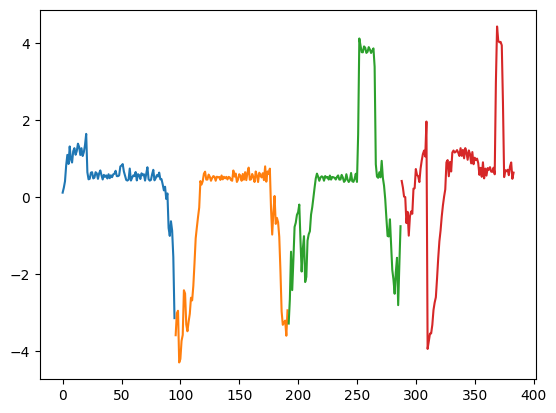

In [11]:
for i in range(4):
    plt.plot(data["grid"][96 * i:96 * (i+1)])

In [ ]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.width', 10000)
pd.set_option('display.max_columns', 100)
SHIFTABLE = ['air', 'car', 'clotheswasher', 'dishwasher', 'dry']
TIME_SHIFTABLE = ['car', 'clotheswasher', 'dishwasher', 'dry']
NON_SHIFTABLE = ['bathroom1', 'bathroom2', 'bedroom1', 'bedroom2', 'bedroom3', 'diningroom1', 'disposal1', 'furnace1',
                 'furnace2', 'garage1', 'kitchen1', 'kitchen2', 'kitchenapp1', 'kitchenapp2', 'lights_plugs1',
                 'lights_plugs2', 'lights_plugs3', 'lights_plugs4', 'livingroom1', 'microwave1', 'office1', 'oven1',
                 'oven2', 'range1', 'refrigerator1', 'refrigerator2', 'utilityroom1', 'venthood1', 'waterheater1',
                 'waterheater2', 'winecooler1']
DEVICES = ['air', 'car', 'clotheswasher', 'dishwasher', 'dry', 'non-shiftable']
INCLUDE = ['dataid', 'air', 'car', 'clotheswasher', 'dishwasher', 'dry', 'non-shiftable', 'total']

df = pd.read_csv('data/15minute_data_austin.csv', engine='python', encoding="ISO-8859-1", parse_dates=['local_15min'], index_col=['local_15min'])
df.index = pd.to_datetime(df.index, utc=True, infer_datetime_format=True)
df.index.names = ['time']
df = df.tz_convert(None)
df = df.groupby(['dataid']).resample('15T').max()
df = df.drop('dataid', axis=1).reset_index('dataid')
df = df.fillna(0)
df = df.apply(lambda l: np.where(l < 0.1, 0, l))

df['air'] = df[['air1', 'air2', 'air3', 'airwindowunit1']].sum(axis=1).clip(upper=4.0)
df['dry'] = df[['drye1', 'dryg1']].sum(axis=1)
df['car'] = df[['car1', 'car2']].sum(axis=1)
df['dishwasher'] = df['dishwasher1']
df['clotheswasher'] = df['clotheswasher1']

for device, consumption, threshold in zip(TIME_SHIFTABLE, [4, 1, 2, 2], [0.1, 0.1, 0.1, 0.1]):
    df[device] = df[device].apply(lambda x: consumption if x >= threshold else 0)

df['non-shiftable'] = df[NON_SHIFTABLE].sum(axis=1).clip(upper=5.0)
df['total'] = df[DEVICES].sum(axis=1)

# Uncomment to save processed data to csv
df[INCLUDE].to_csv('data/15minute_data_austin_fixed_consumption_new.csv')

# Filter Household
dataid = 661
# df = df.loc[df['dataid'] != 9019]
df = df.loc[df['dataid'] == dataid]

# Filter dates
day = 182
start_date = datetime.datetime.strptime('{} {}'.format(day, 2018), '%j %Y')
end_date = datetime.datetime.strptime('{} {}'.format(day + 1, 2018), '%j %Y')
# start_date = datetime.datetime(2018, 7, 9)
# end_date = datetime.datetime(2018, 7, 10)
df = df.loc[(df.index >= start_date) & (df.index < end_date)]

# create the plot
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize': (11, 4)})
solar_plot = df[DEVICES].plot(linewidth=0.5, marker='.')
solar_plot.set_xlabel('Date')
solar_plot.set_ylabel('Grid Usage kW')

# display the plot
plt.title('Major consumers')
plt.ylabel('Power consumnption (KW)')
plt.show()